In [1]:
!pip install timm
!pip install json5 requests opencv-python-headless numpy pillow matplotlib scipy scikit-image torch torchvision transformers

In [2]:
# Init workspace
!rm -r dataset
!mkdir dataset

# Download dataset and extract it
!gdown 111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
!mv imagenet-a.tar ./dataset
!tar -xf ./dataset/imagenet-a.tar
!mv imagenet-a ./dataset

# Cleanup
!rm ./dataset/imagenet-a.tar

# (optional) Upgrading pytorch for the latest augmentation functions
#!pip install --upgrade torch torchvision torchaudio

Downloading...
From (original): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V
From (redirected): https://drive.google.com/uc?id=111HiEoEvZDdg1Y2EefI6n5dA_p4sMV4V&confirm=t&uuid=2ce50251-f66e-4ee7-9da0-28132e225cc5
To: /home/sagemaker-user/imagenet-a.tar
100%|█████████████████████████████████████████| 688M/688M [00:02<00:00, 264MB/s]


In [3]:
# Init workspace
!rm -r dataset
!mkdir dataset

# Download dataset and extract it
!gdown 1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd
!mv imagenetv2-matched-frequency.tar.gz ./dataset
!tar -xf ./dataset/imagenetv2-matched-frequency.tar.gz
!mv imagenetv2-matched-frequency-format-val ./dataset

# Cleanup
!rm ./dataset/imagenetv2-matched-frequency.tar.gz

# (optional) Upgrading pytorch for the latest augmentation functions
#!pip install --upgrade torch torchvision torchaudio

Downloading...
From (original): https://drive.google.com/uc?id=1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd
From (redirected): https://drive.google.com/uc?id=1WKQGHjHUkIwZT0P2TpU9h-lY-6CnrsDd&confirm=t&uuid=31f40880-b954-48c4-84c0-c6f0865c4602
To: /home/sagemaker-user/imagenetv2-matched-frequency.tar.gz
100%|███████████████████████████████████████| 1.26G/1.26G [00:04<00:00, 307MB/s]


In [4]:
import json
import os
from os import listdir
from os.path import basename, isfile, join
from pathlib import Path
import requests
from contextlib import nullcontext
from copy import deepcopy
from typing import Union
import random
from io import BytesIO

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import zoom as scizoom
import skimage as sk

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision.transforms import v2
from transformers import ViTForImageClassification

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [5]:
# Use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = (224, 224)

In [6]:
def show_image(img):
    plt.imshow(img.squeeze(0).permute(1, 2, 0))

In [7]:
def show_batch_images(batch_tensor):
    """
    Visualizza un batch di immagini contenute in un tensore di shape [B, C, H, W].

    Parameters:
    batch_tensor (torch.Tensor): Tensore contenente il batch di immagini.
                                 Shape [B, C, H, W] dove B è il numero di immagini.
    """
    batch_size = batch_tensor.shape[0]
    fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))

    if batch_size == 1:
        axs = [axs]  # Ensure axs is always a list

    for i, ax in enumerate(axs):
        # Converti il tensore in una immagine PIL e poi in un formato numpy per plt.imshow
        img = transforms.ToPILImage()(batch_tensor[i])
        ax.imshow(img)
        ax.axis('off')

    plt.show()

In [8]:
def load_imagenet_v2_labels() -> list[int]:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    labels = [int(f) for f in listdir(imagenet_v2) if not isfile(join(imagenet_v2, f))]
    labels.sort()

    return labels

In [9]:
def load_model_labels() -> list[str]:

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    path = Path(basename(url))

    # Check if labels file already exists
    if not path.exists():
        response = requests.get(url)
        path.write_text(response.text)

    # Load labels
    with open(path, "r") as f:
        labels = json.load(f)

    return labels

In [10]:
from torchvision.models import resnet50, ResNet50_Weights

def load_resnet50(weights=ResNet50_Weights.DEFAULT):
    return resnet50(weights=weights).to(DEVICE)

In [11]:
def load_model(model_name: str = "google/vit-base-patch16-224") -> ViTForImageClassification:

    # Load the pre-trained model
    return ViTForImageClassification.from_pretrained(model_name).to(DEVICE)

In [12]:
class ImageNetV2(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = load_imagenet_v2_labels() * 10
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        label = idx // 10

        img_folder = os.path.join(self.img_dir, str(label))
        img_path = [join(img_folder, f) for f in listdir(img_folder) if isfile(join(img_folder, f))][idx % (label if label != 0 else 1) - 1]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [13]:
def load_dataset(resize: bool = True) -> torch.utils.data.dataloader.DataLoader:

    imagenet_v2 = "./dataset/imagenetv2-matched-frequency-format-val"

    # Prepare data transformations for the train loader
    transforms = [] if not resize else [T.Resize(SIZE)]
    transforms.append(T.ToTensor())
    transform = T.Compose(transforms)

    # Load data
    imagenet_v2_dataset = ImageNetV2(annotations_file=[], img_dir=imagenet_v2, transform=transform)
    return torch.utils.data.DataLoader(imagenet_v2_dataset, 1, shuffle=True, num_workers=8)

In [14]:
def classify(model: ViTForImageClassification, img: torch.Tensor, no_grad: bool = True) -> dict:

    # Use GPU if available
    img = img.to(DEVICE)

    # Perform inference
    model.eval()

    with torch.no_grad() if no_grad else nullcontext():
        outputs = model(img)

    # Extract probabilities from model's output logits
    results = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    return results

def classify_resnet50(model, img):

    # Use GPU if available
    img = img.to(DEVICE)

    # Perform inference
    model.eval()

    with torch.no_grad():
        probabilities = model(img)

    return probabilities.squeeze()

In [15]:
def elaborate_results(results: torch.Tensor) -> Union[dict, list]:

    # Load model's labels
    model_labels = load_model_labels()

    if len(results.shape) == 1:
        results = [results]

    # Process results
    final_results = []

    for result in results:

        item_results = {
            "predicted": {},
            "results": {}
        }

        predicted = None

        for index, probability in enumerate(result):

            item_results["results"][index] = {
                "index": index,
                "label": model_labels[index],
                "probability": probability.item()
            }

            if predicted is None or predicted["probability"] < probability.item():
                predicted = item_results["results"][index]

        item_results["predicted"] = predicted

        final_results.append(item_results)

    return final_results if len(final_results) > 1 else final_results[0]


In [16]:
# # Load model (only once)
# model = load_model()

# # Load data (only once)
# data_loader = load_dataset()

# # Evaluate the model (Accuracy: 18.37 %)
# accuracy = 0

# for index, img in enumerate(data_loader):

#     # Get model prediction
#     results = classify(model=model, img=img[0])
#     results = elaborate_results(results=results)
#     predicted, results = results["predicted"], results["results"]

#     if img[1].item() == predicted["index"]:
#         accuracy = accuracy + 1

#     print(f"Image {index+1} / {len(data_loader)} | Accuracy: {round((accuracy / (index + 1)) * 100, 2)}% ({accuracy} / {index + 1})")

# accuracy = accuracy / len(data_loader)

In [17]:
"""
AUGMENTATIONS
"""

"""helper for zoom_blur"""
def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / zoom_factor))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]

"""helper for defocus_blur"""
def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)

def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (2, 0), (5, 0.1), (20, 0.2)][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255

def pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x = x.resize((int(SIZE[0] * c), int(SIZE[0] * c)), Image.BOX)
    x = x.resize(SIZE, Image.BOX)

    return x

def jpeg_compression(x, severity=1):
    c = [25, 18, 15, 10, 7][severity - 1]

    output = BytesIO()
    x.save(output, 'JPEG', quality=c)
    x = Image.open(output)

    return x

def brightness(x, severity=1):
    c = [.1, .2, .3, .4, .5][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255

def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
        np.arange(1, 1.16, 0.01),
        np.arange(1, 1.21, 0.02),
        np.arange(1, 1.26, 0.02),
        np.arange(1, 1.31, 0.03)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        zoomed = clipped_zoom(x, zoom_factor)
        resized_zoomed = cv2.resize(zoomed, (out.shape[1], out.shape[0]))
        out += resized_zoomed

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255

def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    for d in range(3):
        channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x224x224 -> 224x224x3

    return np.clip(channels, 0, 1) * 255

def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

def shot_noise(x, severity=1):
    c = [60, 25, 12, 5, 3][severity - 1]

    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / c, 0, 1) * 255

def impulse_noise(x, severity=1):
    c = [.03, .06, .09, 0.17, 0.27][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255

def speckle_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255

In [18]:
def augment(img, augmentation_function, severity):
  img = img * 255
  img = img.to(torch.uint8)

  img_np = img.numpy().transpose(0, 2, 3, 1)
  augmented_np = augmentation_function(img_np, severity=severity)

  augmented_tensor = torch.tensor(augmented_np, dtype=torch.uint8).permute(0, 3, 1, 2)
  return augmented_tensor

In [19]:
# crea un batch di n immagini, in cui ognugna è una versione augmented dell'immagine
# se n < numero augmentations allora ne prende una diversa ogni volta, altrimetni random

def create_batch(img, n):
    augmentations = [saturate, brightness, gaussian_noise, shot_noise, impulse_noise, speckle_noise]
    img = classify_transformations(img)
    a = set()
    augmented = []
    while len(augmented) < n-1:
        i = random.randint(0, len(augmentations)-1)
        if len(augmented) == len(augmentations):
            a.clear()
        if i in a: continue
        a.add(i)
        augmented_img = augment(img, augmentations[i], severity=2)
        augmented.append(classify_transformations(augmented_img))
    return torch.cat(augmented, dim=0)


from timm.data.auto_augment import rand_augment_transform
from torchvision import transforms

tfm = rand_augment_transform(
    config_str="rand-m8-inc1-mstd1.01",
    hparams={}
)

classify_transformations = v2.Compose([
    v2.Resize(SIZE),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# crea batch di n immagini, in cui ognuna è stata augmetned con timm
def create_batch_timm(img, n=None, transform=tfm):
    augmented = []
    augmented.append(classify_transformations(img))
    img = transforms.ToPILImage()(img.squeeze(0))
    for _ in range(n-1):
        augmented_img = transform(img)
        augmented_tensor = transforms.ToTensor()(augmented_img).unsqueeze(0)
        augmented.append(classify_transformations(augmented_tensor))
    return torch.cat(augmented, dim=0)

In [20]:
data_loader = load_dataset(resize=False)
for image, label in data_loader:
 img = image
 break


In [21]:
img = classify_transformations(img)
img.shape

torch.Size([1, 3, 224, 224])

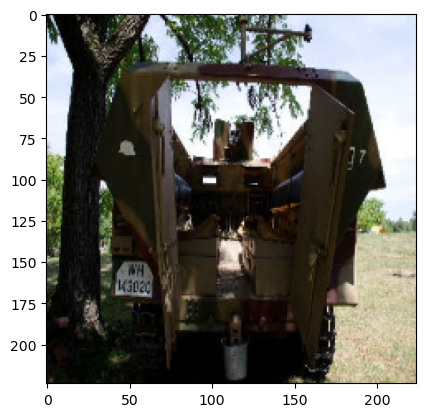

In [22]:
show_image(img)

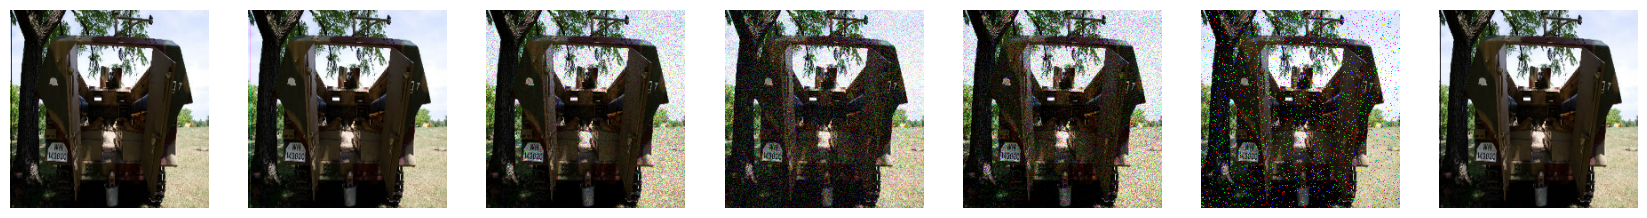

In [23]:
old_batch = create_batch(img, n=8)
show_batch_images(old_batch)

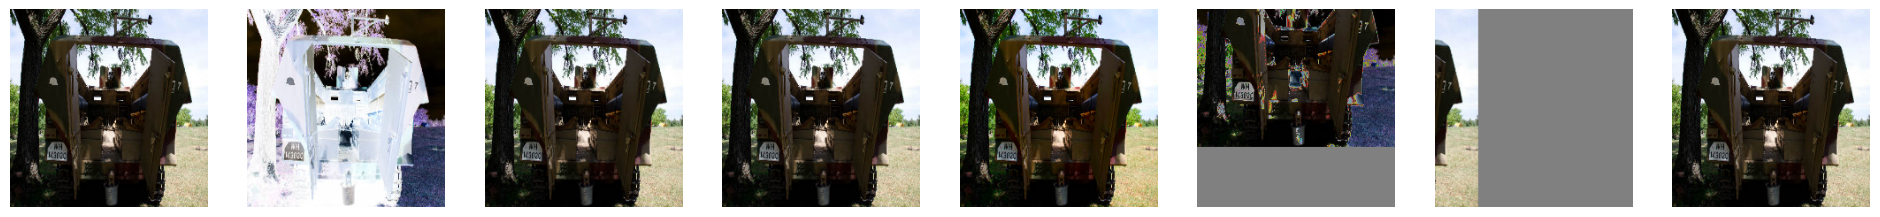

In [24]:
new_batch = create_batch_timm(img, n=8)
show_batch_images(new_batch)

In [25]:
from tqdm import tqdm

def evaluate(n=8, _create_batch=create_batch_timm, to_stop=5000, filename="outputs.txt"):
    accuracy_before = 0
    accuracy_after = 0
    
    # Load model (only once)
    model = load_model()
    original_model = deepcopy(model)
    
    data_loader = load_dataset(resize=False)
    
    # Salva lo stato iniziale del modello
    initial_state = model.state_dict().copy()
    
    for index, img in enumerate(tqdm(data_loader, desc="Processing images")):
        if index >= to_stop:
            break

        # Ripristina lo stato iniziale del modello
        model = deepcopy(original_model)
        optimizer = optim.AdamW(model.parameters(), lr=5e-5)
        # Azzera i gradienti prima di calcolare i nuovi
        optimizer.zero_grad()
    
        # Immagine ridimensionata (384x384)
        img1 = classify_transformations(img[0])
        inputs = _create_batch(img[0], n)
    
        # Classificazione dell'immagine 1 prima delle augmentation
        results = classify(model=model, img=img1)
        results = elaborate_results(results=results)
        predicted, results = results["predicted"], results["results"]
    
        # Aggiorna accuracy della classificazione senza augmentation
        if img[1].item() == predicted["index"]:
            accuracy_before += 1
    
        predicted_before = predicted["label"]
    
        # Calcola gli output delle immagini
        output = model(inputs.to(DEVICE))
    
        # Combina le probabilità delle immagini
        probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze().to(DEVICE)
    
        # Calcolo entropia
        marginal = torch.mean(probabilities, dim=0).to(DEVICE)
        entropy = -torch.sum(marginal * torch.log(marginal)).to(DEVICE)
        entropy.backward()
    
        # Gradient step
        optimizer.step()
    
        # Classificazione dell'immagine 1 dopo le augmentation
        results = classify(model=model, img=img1)
        results = elaborate_results(results=results)
        predicted, results = results["predicted"], results["results"]
    
        # Aggiorna accuracy della classificazione con augmentation
        if img[1].item() == predicted["index"]:
            accuracy_after += 1
    
        label1 = f"Image {index + 1} / {len(data_loader)}"
        label2 = f"Accuracy before: {round((accuracy_before / (index + 1)) * 100, 1)}% ({accuracy_before} / {index + 1})"
        label3 = f"Accuracy after: {round((accuracy_after / (index + 1)) * 100, 1)}% ({accuracy_after} / {index + 1})"
        label4 = f"Diff: {round((accuracy_after / (index + 1)) * 100 - (accuracy_before / (index + 1)) * 100, 2)}%"
    
        string = f"with {_create_batch.__name__} and {n} augs\n" + f"{label1} | {label2} | {label3} | {label4}\n"
        #tqdm.write(string)  # Per visualizzare il progresso in tqdm
    
    with open(filename, 'a') as file:
        file.write(string)
        file.write("\n")


In [ ]:
evaluate(n=2, _create_batch=create_batch_timm, to_stop=5000, filename="outputs1.txt")
evaluate(n=4, _create_batch=create_batch_timm, to_stop=5000, filename="outputs1.txt")
evaluate(n=6, _create_batch=create_batch_timm, to_stop=5000, filename="outputs1.txt")
evaluate(n=8, _create_batch=create_batch_timm, to_stop=5000, filename="outputs1.txt")
evaluate(n=10, _create_batch=create_batch_timm, to_stop=5000, filename="outputs1.txt")

evaluate(n=2, _create_batch=create_batch, to_stop=5000, filename="outputs2.txt")
evaluate(n=4, _create_batch=create_batch, to_stop=5000, filename="outputs2.txt")
evaluate(n=6, _create_batch=create_batch, to_stop=5000, filename="outputs2.txt")
evaluate(n=8, _create_batch=create_batch, to_stop=5000, filename="outputs2.txt")
evaluate(n=10, _create_batch=create_batch, to_stop=5000, filename="outputs2.txt")

Processing images:   3%|▎         | 349/10000 [01:09<29:45,  5.41it/s]

In [ ]:
# Supponendo che load_dataset, classify_image, merged_labels e il modello siano definiti altrove
accuracy_before = 0
accuracy_after = 0

# Load model (only once)
model = load_model()
original_model = deepcopy(model)

data_loader = load_dataset(resize=False)

# Salva lo stato iniziale del modello
initial_state = model.state_dict().copy()

for index, img in enumerate(data_loader):
    if index >= 5001: break
    # Ripristina lo stato iniziale del modello
    model = deepcopy(original_model)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    # Azzera i gradienti prima di calcolare i nuovi
    optimizer.zero_grad()

    # Immagine ridimensionata (384x384)
    img1 = classify_transformations(img[0])
    inputs = create_batch_timm(img[0], 5)

    # Classificazione dell'immagine 1 prima delle augmentation
    results = classify(model=model, img=img1)
    results = elaborate_results(results=results)
    predicted, results = results["predicted"], results["results"]

    # Aggiorna accuracy della classificazione senza augmentation
    if img[1].item() == predicted["index"]:
        accuracy_before = accuracy_before + 1

    predicted_before = predicted["label"]

    # Calcola gli output delle immagini
    output = model(inputs.to(DEVICE))

    # Combina le probabilità delle immagini
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze().to(DEVICE)

    # Calcolo entropia
    marginal = torch.mean(probabilities, dim=0).to(DEVICE)
    entropy = -torch.sum(marginal * torch.log(marginal)).to(DEVICE)
    entropy.backward()

    # Gradient step
    optimizer.step()

    # Classificazione dell'immagine 1 dopo le augmentation
    results = classify(model=model, img=img1)
    results = elaborate_results(results=results)
    predicted, results = results["predicted"], results["results"]

    #print(probabilities1 == probabilities2)
    # Aggiorna accuracy della classificazione con augmentation
    if img[1].item() == predicted["index"]:
        accuracy_after = accuracy_after + 1

    label1 = f"Image {index + 1} / {len(data_loader)}"
    label2 = f"Accuracy before: {round((accuracy_before / (index + 1)) * 100, 1)}% ({accuracy_before} / {index + 1})"
    label3 = f"Accuracy after: {round((accuracy_after / (index + 1)) * 100, 1)}% ({accuracy_after} / {index + 1})"
    label4 = f"Diff: {round((accuracy_after / (index + 1)) * 100 - (accuracy_before / (index + 1)) * 100, 2)}%"

    print(f"{label1} | {label2} | {label3} | {label4}")